# DESeq2 Analysis

* What is it?

  Run fancy stats to find the most variable and most significant genes between two groups of data.


DESeq2 is the main RNA-seq analysis software used in research today. It normalises tables and performs significance tests against multiple samples, and produces useful plots.

* PCA plots
* MA plots
* Volcano plots (sort of)

### Requirements:

DESeq2 needs 3 things to run:

1. integer count matrix (with at least 2 replicates per sample)
2. phenotype data
3. a design (or contrast)


### Let's load in our data

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Load a Raw input matrix

In [2]:
input_tab = read_tsv("raw_count.tsv.gz")  ## Load in raw_count.tsv
input_tab %>% head()

Rows: 9161 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): gene
dbl (8): MUT_2-1, MUT_2-2, MUT_2.5-1, MUT_2.5-2, WT_2-1, WT_2-2, WT_2.5-1, W...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gene,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0610009L18Rik,0,0,0,0,0,0,0,0
0610012D04Rik,53,6063,46,4879,3173,3287,647,5574
0610037L13Rik,0,0,0,0,0,4,3,0
0610040J01Rik,0,0,0,0,0,0,0,0
1110002E22Rik,66,5,135,336,21,116,134,8
1110004F10Rik,418,359,253,25,38,728,1742,143


This is a table, not a matrix.
How to make it a matrix?

In [3]:
input_mat = input_tab %>% column_to_rownames("gene")
input_mat %>% head()

,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0610009L18Rik,0,0,0,0,0,0,0,0
0610012D04Rik,53,6063,46,4879,3173,3287,647,5574
0610037L13Rik,0,0,0,0,0,4,3,0
0610040J01Rik,0,0,0,0,0,0,0,0
1110002E22Rik,66,5,135,336,21,116,134,8
1110004F10Rik,418,359,253,25,38,728,1742,143


### Quick segway into: apply 



We'll make a quick sub table consisting of the first 10 genes only

In [4]:
sub.table <- input_mat[1:10,]

Let's do some whole table operations on this

In [8]:
log(sub.table + 1)
##sqrt(sub.table)

,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0610009L18Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610012D04Rik,3.988984,8.710125,3.850148,8.492900,8.062748,8.098035,6.473891,8.626048
0610037L13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,1.609438,1.386294,0.000000
0610040J01Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1110002E22Rik,4.204693,1.791759,4.912655,5.820083,3.091042,4.762174,4.905275,2.197225
1110004F10Rik,6.037871,5.886104,5.537334,3.258097,3.663562,6.591674,7.463363,4.969813
1110008P14Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1110019D14Rik,0.000000,0.000000,1.609438,0.000000,0.000000,3.258097,1.791759,3.784190
1110028F18Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


You can appreciate how the function that wraps the table, is applied to every element in the table, regardless of row or column.

What if we want to do an individual operation on all rows, or all columns?


In [11]:
head(sub.table)

,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0610009L18Rik,0,0,0,0,0,0,0,0
0610012D04Rik,53,6063,46,4879,3173,3287,647,5574
0610037L13Rik,0,0,0,0,0,4,3,0
0610040J01Rik,0,0,0,0,0,0,0,0
1110002E22Rik,66,5,135,336,21,116,134,8
1110004F10Rik,418,359,253,25,38,728,1742,143


In [16]:
##apply(sub.table, MAR=1, sum)
##apply(sub.table, MAR=1, function(row){
##    sum(row)
##})

apply(sub.table, MAR=2, sum)
apply(sub.table, 2, function(col){
    sum(col)
})

MUT_2-1   MUT_2-2 MUT_2.5-1 MUT_2.5-2    WT_2-1    WT_2-2  WT_2.5-1  WT_2.5-2 
      537      6427       438      5240      3232      4160      2531      5768

MUT_2-1   MUT_2-2 MUT_2.5-1 MUT_2.5-2    WT_2-1    WT_2-2  WT_2.5-1  WT_2.5-2 
      537      6427       438      5240      3232      4160      2531      5768

So we can see how the margin argument (1, 2, or 1:2) affects how we cut the table.
We can also see that the last argument is an implicit function that applies to the cut of the table.

In [22]:
log(sub.table + 1) 
apply(sub.table, MAR=1:2, log)
apply(sub.table, MAR=1:2, function(element){
    log(element + 1)
})

,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
0610009L18Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610012D04Rik,3.988984,8.710125,3.850148,8.492900,8.062748,8.098035,6.473891,8.626048
0610037L13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,1.609438,1.386294,0.000000
0610040J01Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1110002E22Rik,4.204693,1.791759,4.912655,5.820083,3.091042,4.762174,4.905275,2.197225
1110004F10Rik,6.037871,5.886104,5.537334,3.258097,3.663562,6.591674,7.463363,4.969813
1110008P14Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1110019D14Rik,0.000000,0.000000,1.609438,0.000000,0.000000,3.258097,1.791759,3.784190
1110028F18Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1110036E04Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Here we see that the above are all equivalent statements.

Why is this important?

Because we're going to be using apply to calculate the geometric mean value of each gene.

## Normalisation

### Method "Median of Ratios"

1. Create a pseudo-reference for each gene:
   - Row-wise Geometric mean (for genes)
2. Calculate Ratio of each sample to this reference
   - For each sample divide the original gene values by the reference gene value
3. Take the Median Ratio value for each sample
   - (Omit any Infinite values)
   - These are your size factors
4. Divide the original matrix column-wise by these size factors
   - This is your normalised (DESeq) matrix


#### 0. Set input matrix

$$X(s,g) = \text{value of gene (g) in sample (s)}$$ 

In [23]:
X_sg = input_mat

#### 1. Create a pseudo-reference for each gene

 $$GeometricMean(g) = exp\left(\frac{1}{n} \Sigma ^n_{i=1}ln\ X_{ig} \right) $$
 
 Row-wise Geometric mean (for genes)
 * g in this case is a row-wise slice of the table
 * i is a sub-element of g, the value of the gene g for a given sample.

In [24]:
## Function for the Geometric Mean
geometric.mean = function(vec, na.rm=TRUE){
    exp(mean(log(vec),na.rm=na.rm))
}

In [27]:
## Test the geometric mean
geometric.mean(c(5,10,25,30,10000))
mean(c(5,10,25,30,10000))

[1] 51.85686

[1] 2014

In [28]:
##1. Create a pseudo-reference for each gene:
##   - Row-wise Geometric mean (for genes)
GeometricMean_g = apply(X_sg, MAR=1, geometric.mean)

In [32]:
## This is our fake "pseudo" sample.
as.data.frame(GeometricMean_g) %>% head()

,GeometricMean_g
,<dbl>
0610009L18Rik,0.0000
0610012D04Rik,1132.8545
0610037L13Rik,0.0000
0610040J01Rik,0.0000
1110002E22Rik,50.0043
1110004F10Rik,224.8815


#### 2. Calculate Ratio of each sample to this reference

 $$R(s,g) = \frac{X_{sg}}{GeometricMean(g)}$$

For each sample divide the original gene values by the reference gene value

In [34]:
##2. Calculate Ratio of each sample to this reference
##   - For each sample divide the original gene values by the reference gene value
R_sg = X_sg / GeometricMean_g
R_sg %>% head()

,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0610009L18Rik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0610012D04Rik,0.04678447,5.35196703,0.04060539,4.3068196,2.8008892,2.90152,0.5711236,4.9203141
0610037L13Rik,NaN,NaN,NaN,NaN,NaN,Inf,Inf,NaN
0610040J01Rik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1110002E22Rik,1.31988640,0.09999139,2.69976763,6.7194217,0.4199639,2.31980,2.6797694,0.1599862
1110004F10Rik,1.85875641,1.59639605,1.12503677,0.1111696,0.1689779,3.23726,7.7463006,0.6358904


In [37]:
## Na.omit kicks out any nonsense values
mean (na.omit( c(5,6,NaN,12,4) ) )

[1] 6.75

#### 3. Take the Median Ratio value for each sample

- (Omit any Infinite values)
- These are your **size factors**


In [38]:
Median_Rs = apply(na.omit(R_sg), MAR=2, median)  ## Get the median size factor of each sample
as.data.frame(Median_Rs)

,Median_Rs
,<dbl>
MUT_2-1,1.071585
MUT_2-2,1.188386
MUT_2.5-1,1.100031
MUT_2.5-2,1.057425
WT_2-1,1.065772
WT_2-2,1.032221
WT_2.5-1,1.086205
WT_2.5-2,1.073525


#### 4. Divide the original matrix column-wise by these size factors

$$DESeq(s,g) = \frac{X_{sg}}{Median(R_s)}$$

This is your normalised (DESeq) matrix

In [39]:
normalised_deseq2_matrix = X_sg / Median_Rs
normalised_deseq2_matrix %>% head()

,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0610009L18Rik,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000
0610012D04Rik,44.59832,5511.662198,43.50189,4577.90303,3073.95378,3026.130893,602.68738,5201.638335
0610037L13Rik,0.00000,0.000000,0.00000,0.00000,0.00000,3.726043,2.79959,0.000000
0610040J01Rik,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000
1110002E22Rik,61.92695,4.843923,124.28587,312.98758,19.59713,97.611422,121.81473,7.565545
1110004F10Rik,404.95199,330.508363,235.67219,23.32992,31.97616,661.799452,1647.39753,134.175063


## Generating Phenotype Data

Phenotype data should contain some kind of information about your samples. This could include anything from:

* Sequencing lane
* Number of fragments sequenced
* Condition of sample (WT, Mutant, other)
* Tissue
* Time of sequencing

These are all factors that could greatly impact the analysis, so you should **always** have a phenotype data table for any of your analyses.

Essentially, we want a table that looks like this:

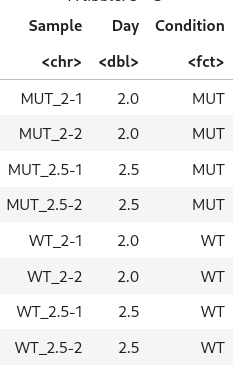

In [53]:
as.factor(c("one", "two", "three", "two", "one"))

[1] one   two   three two   one  
Levels: one three two

In [41]:
as_tibble(colnames(input_mat))

value
<chr>
MUT_2-1
MUT_2-2
MUT_2.5-1
MUT_2.5-2
WT_2-1
WT_2-2
WT_2.5-1
WT_2.5-2


In [90]:
## colnames(input_mat) -- this produces a list of the headers
## as_tibble(...) --- converts this "list" into a "tibble" (table)
phenotype_data = as_tibble(colnames(input_mat)) %>% 
    ## Separate the replicate into a separate column: "MUT_2-1" → c("MUT_2", "1")
    separate(value, into=c("Day_Sample", "Replicate"), sep="-", remove=FALSE) %>%
    ## Separate the day and condition into separate columns: "MUT_2" → c("MUT", "2")
    separate(Day_Sample, into=c("Condition", "Day"), sep="_") %>%
    ## Remove the unwanted Day_Sample column
    ## Cast the Day column from "string" into numeric data
    mutate(Day = as.numeric(Day)) %>%
    ## Coerce the Condition column from "string" into factor data
    ## Condition now takes on finite string values (either: WT or MUT)
    mutate(Condition = as.factor(Condition)) %>% 
    ## Rename "value" 
    mutate(Sample = value) %>%
    ## Reorder the columns: Sample, Day, Condition, Replicate
    relocate(c(Sample, Day, Condition, Replicate)) %>%
    ## Remove the replicate column
    select(-c(Replicate, value))

In [91]:
## Store the above into variable "phenotype_data"
phenotype_data

Sample,Day,Condition
<chr>,<dbl>,<fct>
MUT_2-1,2.0,MUT
MUT_2-2,2.0,MUT
MUT_2.5-1,2.5,MUT
MUT_2.5-2,2.5,MUT
WT_2-1,2.0,WT
WT_2-2,2.0,WT
WT_2.5-1,2.5,WT
WT_2.5-2,2.5,WT


The phenotype data annotates our samples with Factors that could impact the analysis. We will use these later.

# DESeq2 Analysis

We have our three requirements:

1. integer replicate matrix (with at least two replicates per sample)
2. phenotype data describing our samples
3. design (we will play with this more later)


Here we will perform DESeq2 analysis. The aim is to find the most variable genes in the analysis that can explain the variation between our cases and controls.

In [58]:
library(DESeq2)

Let's create DESeq object, which takes as arguments:
* input matrix of integers, genes as rows, samples as columns
* phenotype data containing factor
* design matrix, telling DESeq what is groupA vs groupB

In [61]:
phenotype_data

Sample,Day,Condition
<chr>,<dbl>,<fct>
MUT_2-1,2.0,MUT
MUT_2-2,2.0,MUT
MUT_2.5-1,2.5,MUT
MUT_2.5-2,2.5,MUT
WT_2-1,2.0,WT
WT_2-2,2.0,WT
WT_2.5-1,2.5,WT
WT_2.5-2,2.5,WT


In [62]:
ddsObj = DESeqDataSetFromMatrix(
    countData = input_mat,
    colData = phenotype_data,
    design = ~Condition
)

converting counts to integer mode



In [71]:
ddsObj

DataFrame with 8 rows and 3 columns
               Sample       Day Condition
          <character> <numeric>  <factor>
MUT_2-1       MUT_2-1       2.0       MUT
MUT_2-2       MUT_2-2       2.0       MUT
MUT_2.5-1   MUT_2.5-1       2.5       MUT
MUT_2.5-2   MUT_2.5-2       2.5       MUT
WT_2-1         WT_2-1       2.0       WT 
WT_2-2         WT_2-2       2.0       WT 
WT_2.5-1     WT_2.5-1       2.5       WT 
WT_2.5-2     WT_2.5-2       2.5       WT 

We can inspect the object further with "colData"

In [72]:
colData(ddsObj)

DataFrame with 8 rows and 3 columns
               Sample       Day Condition
          <character> <numeric>  <factor>
MUT_2-1       MUT_2-1       2.0       MUT
MUT_2-2       MUT_2-2       2.0       MUT
MUT_2.5-1   MUT_2.5-1       2.5       MUT
MUT_2.5-2   MUT_2.5-2       2.5       MUT
WT_2-1         WT_2-1       2.0       WT 
WT_2-2         WT_2-2       2.0       WT 
WT_2.5-1     WT_2.5-1       2.5       WT 
WT_2.5-2     WT_2.5-2       2.5       WT 

And we can access the assay itself, via: 

In [73]:
assay(ddsObj) %>% head()  ## we just use head because we don't want to print the entire matrix

,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
0610009L18Rik,0,0,0,0,0,0,0,0
0610012D04Rik,53,6063,46,4879,3173,3287,647,5574
0610037L13Rik,0,0,0,0,0,4,3,0
0610040J01Rik,0,0,0,0,0,0,0,0
1110002E22Rik,66,5,135,336,21,116,134,8
1110004F10Rik,418,359,253,25,38,728,1742,143


Let's perform the actual analysis, with "DESeq"

In [74]:
ddsObj = DESeq(ddsObj)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



We can inspect these ourselves

In [75]:
as.data.frame(sizeFactors(ddsObj))

,sizeFactors(ddsObj)
,<dbl>
MUT_2-1,1.071585
MUT_2-2,1.188385
MUT_2.5-1,1.100028
MUT_2.5-2,1.057425
WT_2-1,1.065771
WT_2-2,1.032221
WT_2.5-1,1.086202
WT_2.5-2,1.073525


* Estimating the dispersions

  What exactly is dispersion? We can plot it below.

In [76]:
stat_data = data.frame(Mean = apply(assay(ddsObj), MAR=1, mean),  ## remember how apply works?
                       Var = apply(assay(ddsObj), MAR=1, var))
stat_data %>% head()

,Mean,Var
,<dbl>,<dbl>
0610009L18Rik,0.000,0.000000e+00
0610012D04Rik,2965.250,6.084037e+06
0610037L13Rik,0.875,2.696429e+00
0610040J01Rik,0.000,0.000000e+00
1110002E22Rik,102.625,1.188055e+04
1110004F10Rik,463.250,3.196965e+05


### First naive dispersion plot

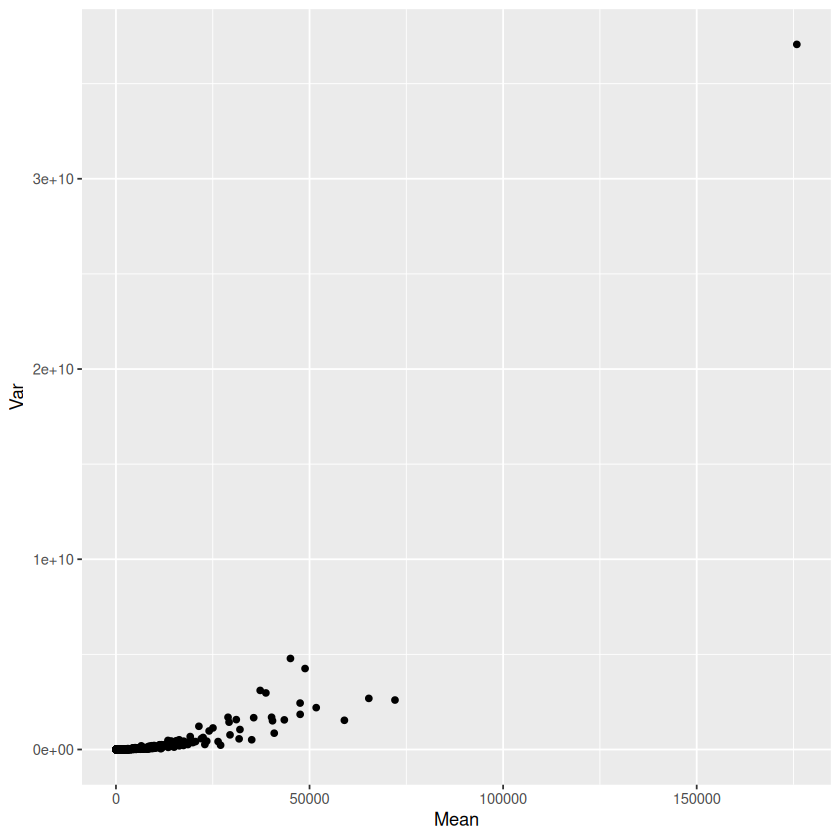

In [79]:
stat_data %>%
    ggplot(aes(x=Mean, y=Var)) + 
    geom_point()

Need to **regularize** the data:
- Transform all data points equally, such that expression space is small
  - (i.e. Log transformation)

In [80]:
log(assay(ddsObj) + 1) %>% head()   ## why do we add 1?

,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
0610009L18Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610012D04Rik,3.988984,8.710125,3.850148,8.492900,8.062748,8.098035,6.473891,8.626048
0610037L13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,1.609438,1.386294,0.000000
0610040J01Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1110002E22Rik,4.204693,1.791759,4.912655,5.820083,3.091042,4.762174,4.905275,2.197225
1110004F10Rik,6.037871,5.886104,5.537334,3.258097,3.663562,6.591674,7.463363,4.969813


### Regularize the Data

In [81]:
## regularized
## This function transforms the count data to the log2 scale in a way which minimizes differences between
## samples for rows with small counts, and which normalizes with respect to library size
ntd = normTransform(ddsObj)

What just happened? Quick comparison of the matrices:

In [85]:
##assay(ddsObj) %>% head()
assay(ntd) %>% head()
log2(assay(ddsObj) + 1) %>% head()

,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
0610009L18Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610012D04Rik,5.657052,12.317096,5.420115,12.172127,11.540218,11.637257,9.220749,12.342419
0610037L13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,2.285443,1.911468,0.000000
0610040J01Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1110002E22Rik,5.967883,2.380560,6.950983,8.316295,4.371840,6.825010,6.958444,3.079307
1110004F10Rik,8.611306,8.243605,7.851712,4.623067,5.195935,9.464087,10.648135,7.068306


,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
0610009L18Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610012D04Rik,5.754888,12.566054,5.554589,12.252665,11.632086,11.682995,9.339850,12.444756
0610037L13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,2.321928,2.000000,0.000000
0610040J01Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1110002E22Rik,6.066089,2.584963,7.087463,8.396605,4.459432,6.870365,7.076816,3.169925
1110004F10Rik,8.710806,8.491853,7.988685,4.700440,5.285402,9.509775,10.767357,7.169925


### Plotting Regularized Mean and Variance

Here we see that Mean and Variance have a linear  relationship with one another:
* We observe that a gene which has a high mean tends to have a high variance.
* We observe that a gene which has a low mean tends to have a low variance.
* Does this then mean that a lowly expressed gene isn't a significant differentially expressed gene in our analysis?
  * Maybe, but it could also be very significant but appears not to be purely because it isn't as highly expressed as other genes.

In [92]:
stat_data = data.frame(Mean = apply(assay(ntd), 1, mean), 
                       Var = apply(assay(ntd), 1, var))
stat_data %>% head()

,Mean,Var
,<dbl>,<dbl>
0610009L18Rik,0.0000000,0.0000000
0610012D04Rik,10.0383792,8.7226951
0610037L13Rik,0.5246139,0.9536003
0610040J01Rik,0.0000000,0.0000000
1110002E22Rik,5.6062903,4.4159303
1110004F10Rik,7.7132691,4.1554278


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


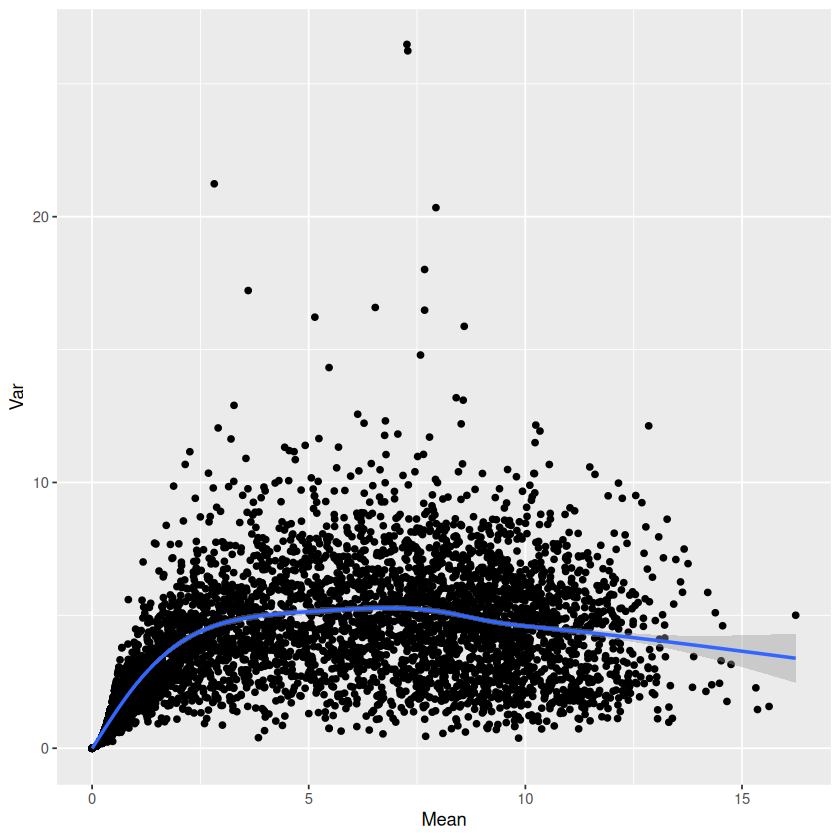

In [93]:
## Plot mean and variance, and apply smoothing
stat_data %>%
    ggplot(aes(x=Mean, y=Var)) +
    geom_point() + 
    geom_smooth()

We can **correct** for this bias, by decoupling the relationship between Mean and Variance, using the DESeq2 Dispersion formula.

### Calculating Dispersion

$$Dispersion = \frac{Var - \mu}{\mu^2}$$

What does this formula do?
* Note that as the variance increases, Dispersion increases too (this is good)
* Note also that as the mean increases, Dispersion decreases (this is also good)

So we have a new metric for the variability in our analysis called "Dispersion" which is somewhat more robust against larger changes in the mean.

### Plotting the Dispersion

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 4129 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 4129 rows containing missing values (`geom_point()`).”


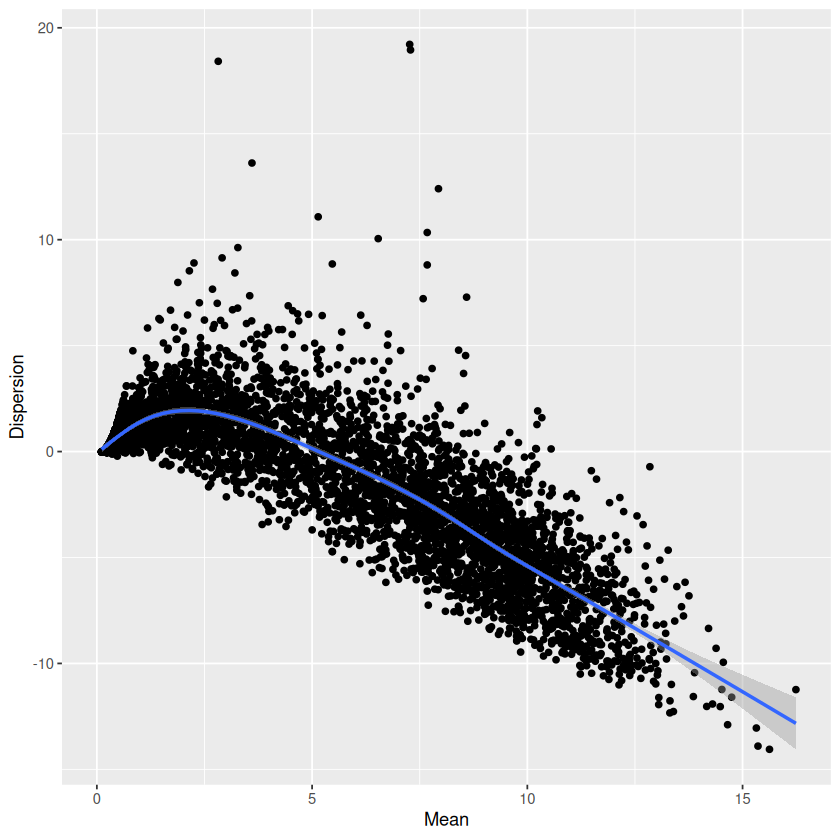

In [94]:
stat_data %>% 
    ## We are doing an operation across rows, not columns, so we tell it
    ## to group rows via "rowwise
    rowwise %>%
    # Here we calculate the dispersion using the above formula
    mutate(Dispersion = (Var - Mean) / Mean*Mean) %>%
    ggplot(aes(x=Mean, y=Dispersion)) +
    geom_point() + 
    geom_smooth()

$$Dispersion = \frac{Variance - \mu}{\mu^2}$$

A metric where:
* As variance increases, dispersion increases
* As the mean expression increases, dispersion decreases

Mean and Variance are still coupled, but the effects of the mean on the variance are reduced. You can see this effect more clearly on the lowly-expressed genes, which have a wider range of variability than they did before.

### Dispersion and MA

The dispersion plot is similar to the one we plotted above, but with maximum likelihood estimates baked in to the data. Each gene is fitted with a negative binomial distribution (i.e. standard normal distribution with a known mean and a known variance,  but for discrete data), and genes that have similar distributions are "binned" into the general distribution. The genes are then "corrected" to the polynomial fit line, but if genes are significantly deviant from the line, then they are *not* corrected. You can see the not corrected genes highlighted in blue.


An [MA plot](https://en.wikipedia.org/wiki/MA_plot) plots the mean value of a gene on the X-axis and the log fold change in expression between two groups on the Y-axis. 

The grey points are not genes of interest because either they do not have a high enough mean, or they do not have a high enough log2 fold change between the contrasting groups.

Each dot above is a gene. X-axis is mean, and Y-axis is dispersion.
So we know that dispersion has something to do with variance maybe?

Let's have a deeper look at our genes using our own metrics.

We will now plot the mean against the variance and see what we can infer

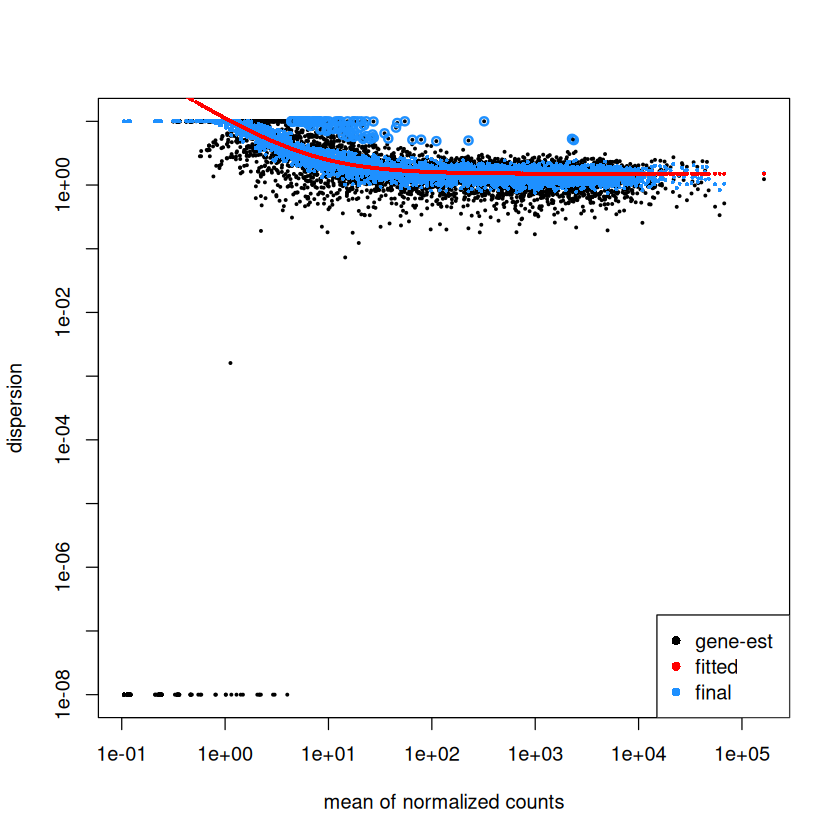

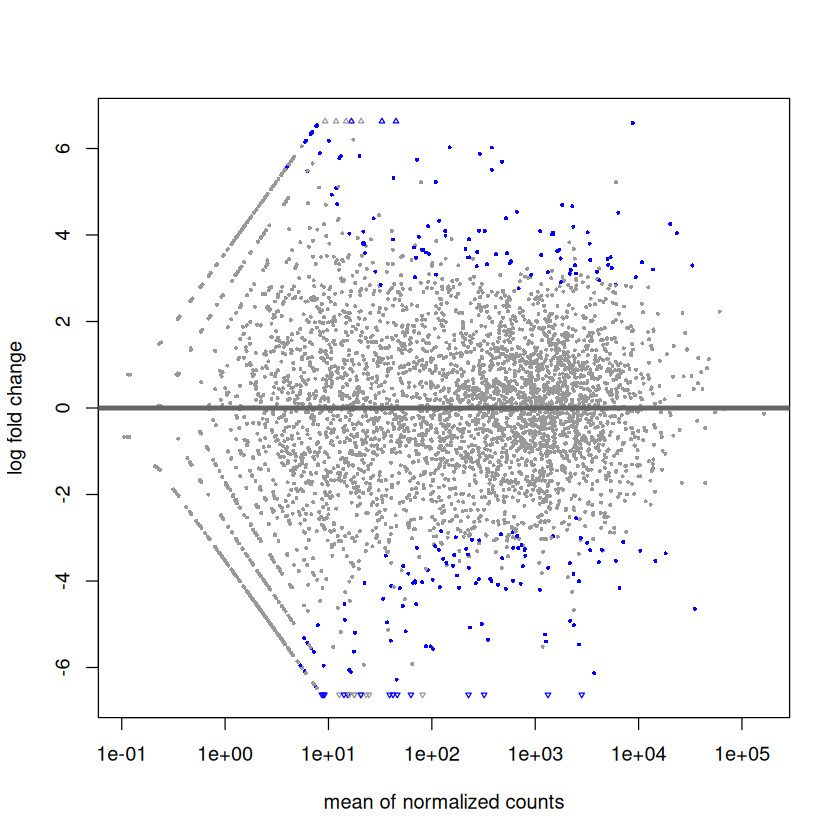

In [95]:
plotDispEsts(ddsObj)
plotMA(ddsObj)

We have some useful plots, but we also can see some strange diagonal patterns that could suggest that our genes have been over corrected.

This could be because we tried to explain all the variation with a single factor "Condition", but that the data might be more variable than that.

### Extracting up/down regulated genes via `results`

In [96]:
res <- results(ddsObj)

In [97]:
res

log2 fold change (MLE): Condition WT vs MUT 
Wald test p-value: Condition WT vs MUT 
DataFrame with 9161 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat    pvalue
                <numeric>      <numeric> <numeric> <numeric> <numeric>
0610009L18Rik    0.000000             NA        NA        NA        NA
0610012D04Rik 2719.583634       0.285038   1.33266  0.213887  0.830635
0610037L13Rik    0.829632       3.314160   3.42667  0.967167  0.333460
0610040J01Rik    0.000000             NA        NA        NA        NA
1110002E22Rik   96.147019      -0.945237   1.25521 -0.753052  0.451419
...                   ...            ...       ...       ...       ...
Zscan4d           1.15080        3.78813   3.41460   1.10939  0.267260
Zswim2            4.17844       -2.64092   1.95280  -1.35238  0.176254
Zswim7            0.00000             NA        NA        NA        NA
Zwint             2.15910       -3.02408   2.16506  -1.39676  0.162484
Zyg11b          239.8383

#### Defining our thresholds of signficance

In [99]:
alpha = 0.05   ## P-value significance threshold
lFC = 2        ## Log2Foldchange signficance threshold

Subset the data to just the signficant results:

In [100]:
res_alpha = subset(res, padj < alpha)
res_alpha_fc = subset(res_alpha, abs(log2FoldChange) > lFC)

In [101]:
dim(res_alpha_fc)

[1] 87  6

Extract up and down regulated genes, based on Log2 Fold change

In [102]:
up_genes = subset(res_alpha_fc, log2FoldChange > 0)
down_genes = subset(res_alpha_fc, log2FoldChange < 0)
nrow(up_genes)
nrow(down_genes)

[1] 39

[1] 48

In [103]:
list(up = rownames(up_genes),
     down = rownames(down_genes))

$up
 [1] "1190002F15Rik" "Actr1a"        "Emc9"          "Gm10549"      
 [5] "Gm13445"       "Gm14476"       "Gm16588"       "Gm18552"      
 [9] "Gm20692"       "Gm24105"       "Gm25200"       "Gm25694"      
[13] "Gm26419"       "Gm26516"       "Gm27997"       "Gm28660"      
[17] "Gm29154"       "Gm29501"       "Gm4810"        "Gm7953"       
[21] "Gm8935"        "Gpr137c"       "Mak"           "March10"      
[25] "Mef2d"         "Mir1a-1"       "Ms4a2"         "Nfatc4"       
[29] "Pqlc2"         "Reln"          "RP23-103L12.1" "RP24-303G10.2"
[33] "RP24-409P22.2" "SCARNA15"      "Tmem132a"      "Tyrp1"        
[37] "Ucn"           "Vmn1r-ps46"    "Ybx1"         

$down
 [1] "2810454H06Rik" "A230108P19Rik" "AC034285.1"    "Apaf1"        
 [5] "Batf3"         "Chga"          "Cnga2"         "Dexi"         
 [9] "E230001N04Rik" "Epb4.1l1"      "Fam32a"        "Fbln5"        
[13] "Gm14931"       "Gm23993"       "Gm25840"       "Gm28394"      
[17] "Gm36986"       "Gm6075"        "Gm8708"        "Gtf2i"        
[21] "Itih5l-ps"     "Mir6954"       "Ocel1"         "Parp10"       
[25] "Pigc"          "Rab3ip"        "Rac3"          "RP24-274I18.1"
[29] "RP24-318J14.1" "RP24-455A5.3"  "Sdr42e1"       "Sh2d1b2"      
[33] "Slc25a47"      "Slc36a2"       "Smarcd1"       "Spred1"       
[37] "Stk3"          "Sult1d1"       "Tdgf1-ps2"     "Tecpr1"       
[41] "Tll1"          "Tlr11"         "Tmem39b"       "Trim55"       
[45] "Trpc4"         "Zfp184"        "Zfp523"        "Zfp870"

## Repeat With Day as a Factor

Let's repeat the entire analysis as above, but instead of specifcing Condition as the only factor in the design matrix, we use Day as well.

Why?
* Maybe the expression of the genes isn't just due to whether a dataset is mutant or wildtype, but also dependent on whether it was sequenced at an earlier time point.

How?
* The design formula is where you list your factors of the analysis, where the last factor given at the end is the main factor we are interested in.
* In our case, Condition is our main factor, and Day is a secondary factor that we wish to correct for.

In [ ]:
phenotype_data

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



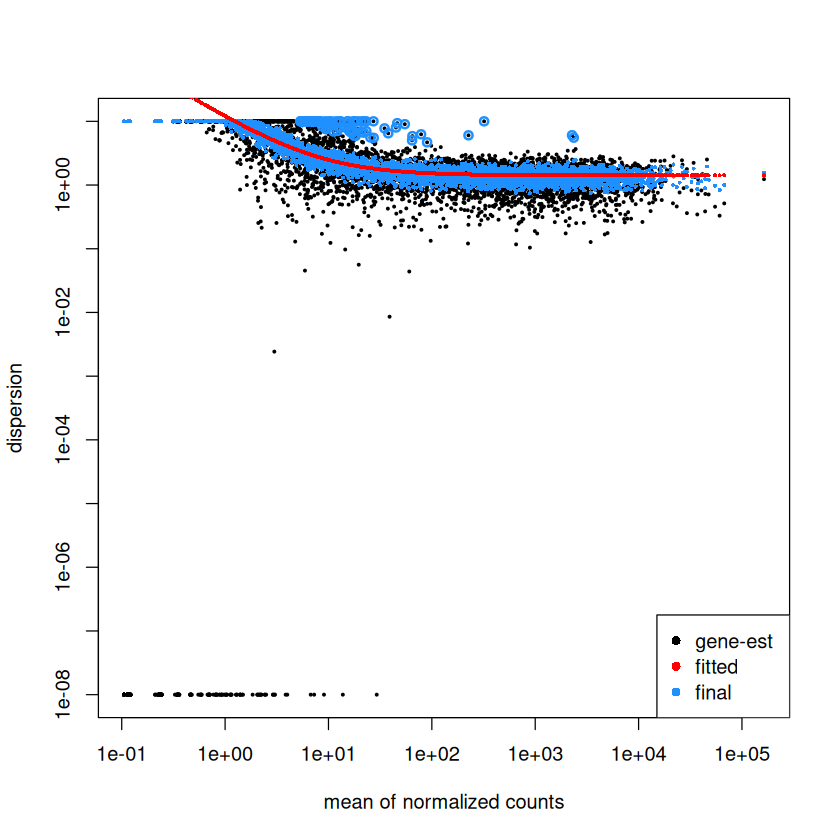

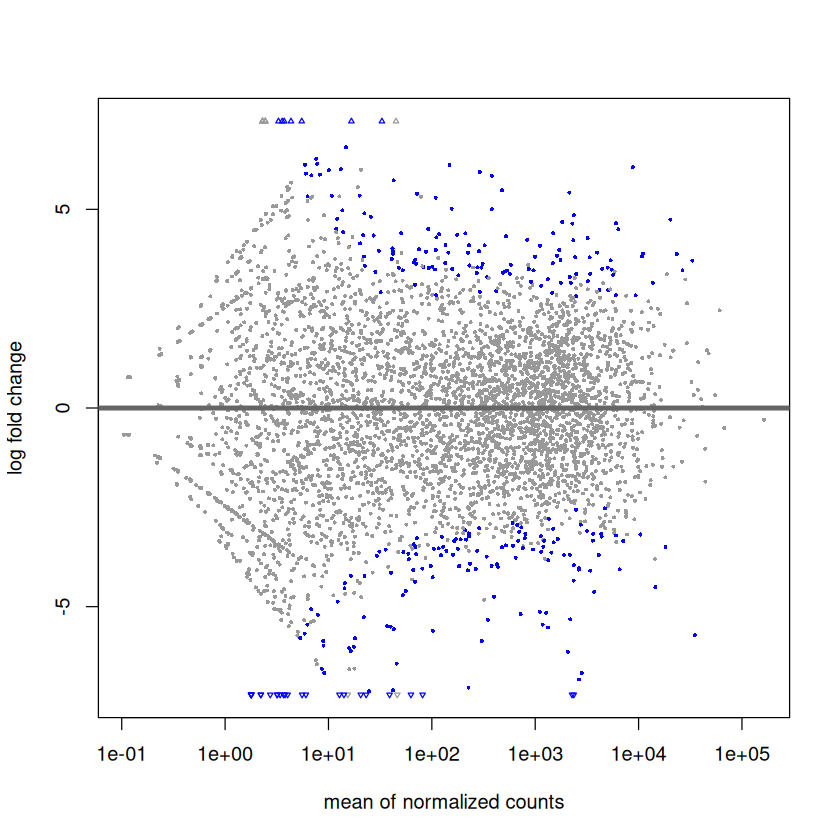

In [105]:
ddsObj = DESeqDataSetFromMatrix(
    countData =  input_mat,
    colData = phenotype_data,
    design = ~Day + Condition    ## Day and Condition, but keep Condition as the main factor
)

ddsObj = DESeq(ddsObj)

plotDispEsts(ddsObj)

plotMA(ddsObj)

Here we see a little bit less over-correction of the genes in the MA plot, but mostly it looks the same.

## Repeat with Day and Condition having an interaction

One thing we should also consider:
* Mean and Variance share a linear relationship, which DESeq corrects for by using a new Dispersion metric.
* Could it also be that some of our factors share an interaction
  * Is the Condition dependent on the Day? or vice versa?
    * e.g. Early embryos haven't quite lived out their entire developmental pathways, so it could be the case that the expression of genes in a mutant embryo are similar as the expression of genes in the wildtype embryo, and that the phenotype of mutant/wildtype becomes stronger with time.
      * If true, you could argue that Condition is dependent somewhat on Day.

To correct for this, we can tell the design formula that "Day" and "Condition" share an interaction via "Day:Condition". Since this is not a main factor we are interested in, we place it at the beginning of the design parameter.

In [ ]:
phenotype_data

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



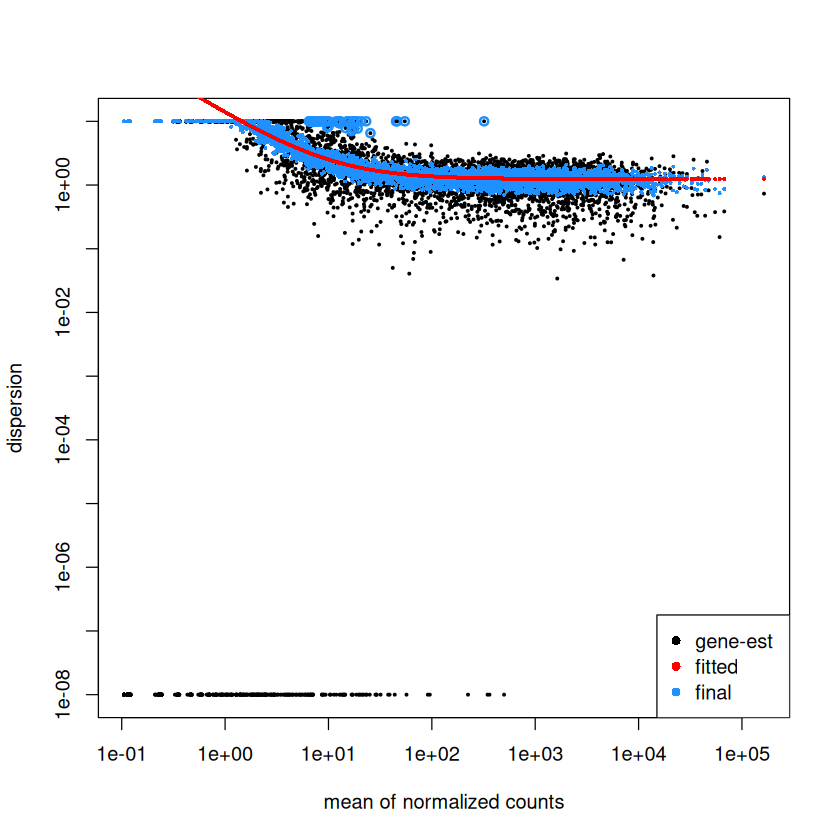

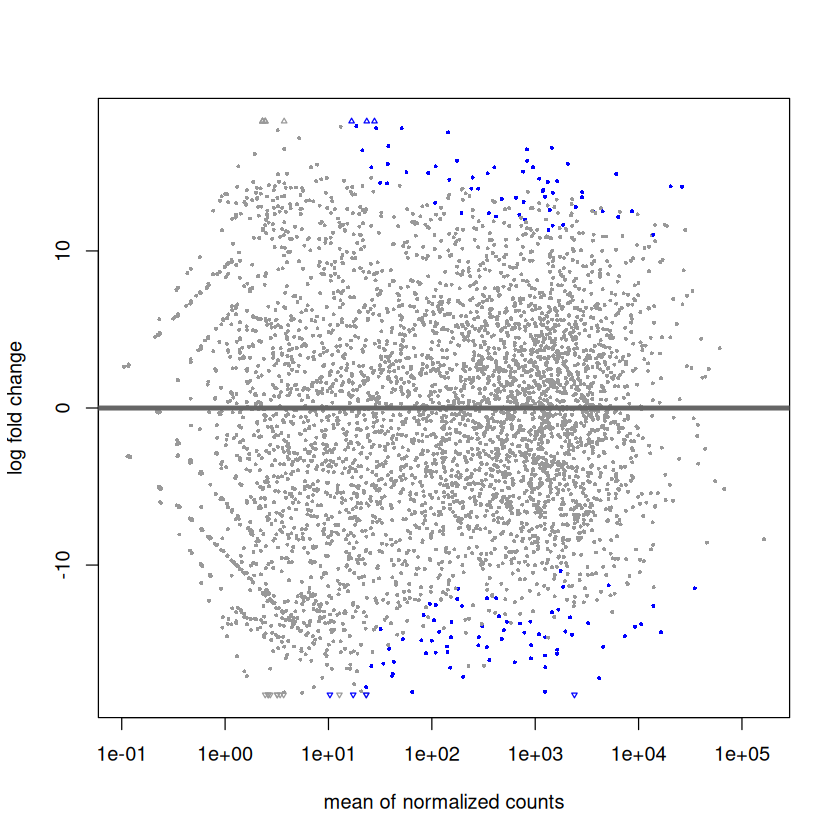

In [106]:
ddsObj = DESeqDataSetFromMatrix(
    countData =  input_mat,
    colData = phenotype_data,
    design = ~Day:Condition + Day + Condition    ## Condition should be the main factor, Day should be a sub factor, Day and condition interaction should be small.
)

ddsObj = DESeq(ddsObj)

plotDispEsts(ddsObj)

plotMA(ddsObj)

Hmm. Nothing really changed. So whatever effect Day and Condition share, it doesn't seem to be super significant. 

Nonetheless we have controlled for everything we can in our analysis, and we can now extract the results of the analysis and use it plot a volcano!

## How do we know what factors to use?

Answer: Anova. First we need to convert this data to long

### Quick segway into: Pivot

In [107]:
test_table = tribble(
  ~country, ~year, ~cases,
  "Angola", 1998, 100,
  "Angola", 1999, 800,
  "Angola", 2000, 750,
  "Angola", 2001, 75,
  "India", 1998, 109,
  "India", 1999, 45,
  "India", 2000, 27,
  "India", 2001, 77,
  "Mongolia", 1998, 22,
  "Mongolia", 1999, 55,
  "Mongolia", 2000, 15,
  "Mongolia", 2001, 38
)
test_table

country,year,cases
<chr>,<dbl>,<dbl>
Angola,1998,100
Angola,1999,800
Angola,2000,750
Angola,2001,75
India,1998,109
India,1999,45
India,2000,27
India,2001,77
Mongolia,1998,22


In [108]:
test_wider = test_table %>% pivot_wider(names_from = "year",
                           values_from = "cases")
test_wider

country,1998,1999,2000,2001
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Angola,100,800,750,75
India,109,45,27,77
Mongolia,22,55,15,38


In [110]:
test_wider %>%
    ## cols=c("1998", "1999", "2000", etc.)  ## is there an easier way to select all the columns we want to pivot?
    pivot_longer(cols=-country,
                 names_to = "year", 
                 values_to = "cases")

country,year,cases
<chr>,<chr>,<dbl>
Angola,1998,100
Angola,1999,800
Angola,2000,750
Angola,2001,75
India,1998,109
India,1999,45
India,2000,27
India,2001,77
Mongolia,1998,22


## Back to Anova

In [112]:
input_tab %>% head()

gene,MUT_2-1,MUT_2-2,MUT_2.5-1,MUT_2.5-2,WT_2-1,WT_2-2,WT_2.5-1,WT_2.5-2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0610009L18Rik,0,0,0,0,0,0,0,0
0610012D04Rik,53,6063,46,4879,3173,3287,647,5574
0610037L13Rik,0,0,0,0,0,4,3,0
0610040J01Rik,0,0,0,0,0,0,0,0
1110002E22Rik,66,5,135,336,21,116,134,8
1110004F10Rik,418,359,253,25,38,728,1742,143


In [115]:
tab_long = input_tab %>% 
    pivot_longer(-gene) %>%
    separate(name, into = c("Condition", "Day", "Replicate"),
             sep="[_-]", remove=FALSE)
tab_long %>% head()

gene,name,Condition,Day,Replicate,value
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
0610009L18Rik,MUT_2-1,MUT,2,1,0
0610009L18Rik,MUT_2-2,MUT,2,2,0
0610009L18Rik,MUT_2.5-1,MUT,2.5,1,0
0610009L18Rik,MUT_2.5-2,MUT,2.5,2,0
0610009L18Rik,WT_2-1,WT,2,1,0
0610009L18Rik,WT_2-2,WT,2,2,0


In [116]:
tab_long$Day = as.numeric(tab_long$Day)  ## we want Day not to be a string

In [117]:
tab_long %>% head()

gene,name,Condition,Day,Replicate,value
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
0610009L18Rik,MUT_2-1,MUT,2.0,1,0
0610009L18Rik,MUT_2-2,MUT,2.0,2,0
0610009L18Rik,MUT_2.5-1,MUT,2.5,1,0
0610009L18Rik,MUT_2.5-2,MUT,2.5,2,0
0610009L18Rik,WT_2-1,WT,2.0,1,0
0610009L18Rik,WT_2-2,WT,2.0,2,0


By specifying: 
* X * Y * Z, we test: X + Y + Z + XY + XZ + YZ + XYZ
* A * B, we test: A + B + AB

In [118]:
#fit the two-way ANOVA model
model <- aov(value ~ Day * Condition, 
             data = tab_long)
#view the model output
summary(model)

                 Df    Sum Sq  Mean Sq F value Pr(>F)  
Day               1 7.389e+07 73893554   3.194 0.0739 .
Condition         1 1.714e+07 17139670   0.741 0.3894  
Day:Condition     1 5.391e+06  5390840   0.233 0.6293  
Residuals     73284 1.695e+12 23132268                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

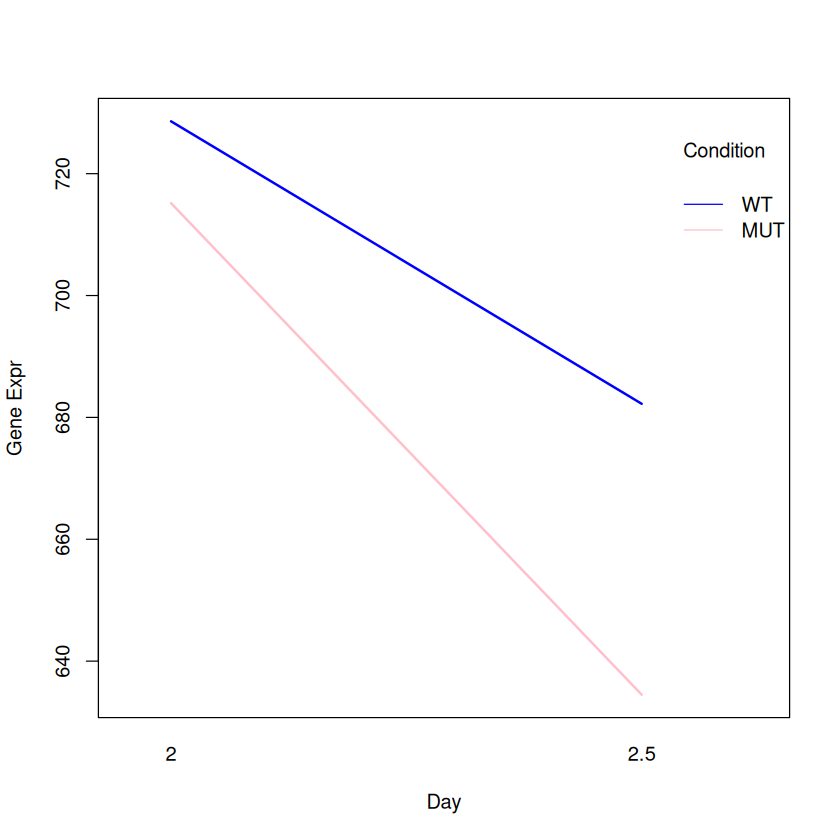

In [119]:
interaction.plot(x.factor = tab_long$Day, #x-axis variable
                 trace.factor = tab_long$Condition, #variable for lines
                 response = tab_long$value, #y-axis variable
                 fun = mean, #metric to plot
                 ylab = "Gene Expr",
                 xlab = "Day",
                 col = c("pink", "blue"),
                 lty = 1, #line type
                 lwd = 2, #line width
                 trace.label = "Condition")

> In general, if the two lines on the interaction plot are parallel then there is no interaction effect. However, if the lines intersect then there is likely an interaction effect.

Likely an interaction in the past, but not something to worry about in the future.

Keeping Condition and Day as independent entities is probably enough.

https://www.statology.org/interaction-plot-r/

We'll use the full design contrast anyway, it doesn't seem to change the analysis much.

In [120]:
ddsObj = DESeqDataSetFromMatrix(
    countData = input_mat,
    colData = phenotype_data,
    design = ~Day:Condition + Day + Condition
)
ddsObj = DESeq(ddsObj)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



# Volcano Plot (i.e. Playing with Plots)

### What is a volcano plot?

Adjusted p-value vs Log2FoldChange

https://en.wikipedia.org/wiki/Volcano_plot_(statistics)


In [122]:
res = results(ddsObj)
as.data.frame(res)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0610009L18Rik,0.000000e+00,NA,NA,NA,NA,NA
0610012D04Rik,2.719584e+03,0.1109216,5.397855,0.02054919,0.9836052698,0.99364831
0610037L13Rik,8.296319e-01,-1.1012729,13.691349,-0.08043567,0.9358907585,NA
0610040J01Rik,0.000000e+00,NA,NA,NA,NA,NA
1110002E22Rik,9.614702e+01,-5.5146408,4.798614,-1.14921545,0.2504671513,0.59291376
1110004F10Rik,4.279615e+02,5.3537808,4.734325,1.13084351,0.2581209616,0.59752863
1110008P14Rik,0.000000e+00,NA,NA,NA,NA,NA
1110019D14Rik,9.064255e+00,-10.5093570,8.136010,-1.29170897,0.1964579491,NA
1110028F18Rik,0.000000e+00,NA,NA,NA,NA,NA


Here you can see that DESeq has calculated some statistics such as baseMean, log2FoldChange, pvalue, and padj (adjusted p-value).

Unfortunately it's printed it into a weird format, and the gene names are not given their own distinct column. Let's put the genes (the row names of the data above) into its own column.

### Convert Results data into a tibble (for tidyverse)

In [123]:
res$gene = rownames(res)

and now let's cast this into a tibble so that we can plot it.

In [124]:
as_tibble(res) %>% head()

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.0000000,NA,NA,NA,NA,NA,0610009L18Rik
2719.5836339,0.1109216,5.397855,0.02054919,0.9836053,0.9936483,0610012D04Rik
0.8296319,-1.1012729,13.691349,-0.08043567,0.9358908,NA,0610037L13Rik
0.0000000,NA,NA,NA,NA,NA,0610040J01Rik
96.1470189,-5.5146408,4.798614,-1.14921545,0.2504672,0.5929138,1110002E22Rik
427.9615211,5.3537808,4.734325,1.13084351,0.2581210,0.5975286,1110004F10Rik


### Calculating the -log10 adj- p-value

A volcano plot uses the -Log10 adjusted p-value, but we only have the adjusted p-value (padj), so we're going to need to compute that ourselves.


In [128]:
# Store data into "pdata" variable
pdata = as_tibble(res) %>% 
    # We are interested in gene, log2FC, and adjusted pvalue
    # We can ignore the other columns
    select(c(gene, log2FoldChange, padj)) %>% 
    # We create a new column "mLog10Padj", which applies -log10 to the padj column.
    mutate(mLog10Padj = -log10(padj))

# Print the "pdata" variable (first 6 lines only)
pdata %>% head()

gene,log2FoldChange,padj,mLog10Padj
<chr>,<dbl>,<dbl>,<dbl>
0610009L18Rik,NA,NA,NA
0610012D04Rik,0.1109216,0.9936483,0.002767302
0610037L13Rik,-1.1012729,NA,NA
0610040J01Rik,NA,NA,NA
1110002E22Rik,-5.5146408,0.5929138,0.227008467
1110004F10Rik,5.3537808,0.5975286,0.223641278


### Initial Plot

Let's do an initial plot. It will be ugly at first, but we will improve this.

We initially pipe the data from "pdata" into ggplot.

GGplot expects three things:
* Data
* Aesthetics
* Drawing tool

__Data__:
The data is piped into it via "pdata", so we no longer need to tell ggplot that "data=pdata", this is implied by piping in "pdata" via "%>%".

__Aesthetics__:
Here is where we define which columns should represent what aspect of the data. You can choose from many different types of aesthetics: `x`, `y`, `color`, `shape`, `fill` (similar to color, but the inside of the shape), `label`, `text` (similar to label, but with a surrounding box), and many many others.

Warning message:
“Removed 5809 rows containing missing values (`geom_point()`).”


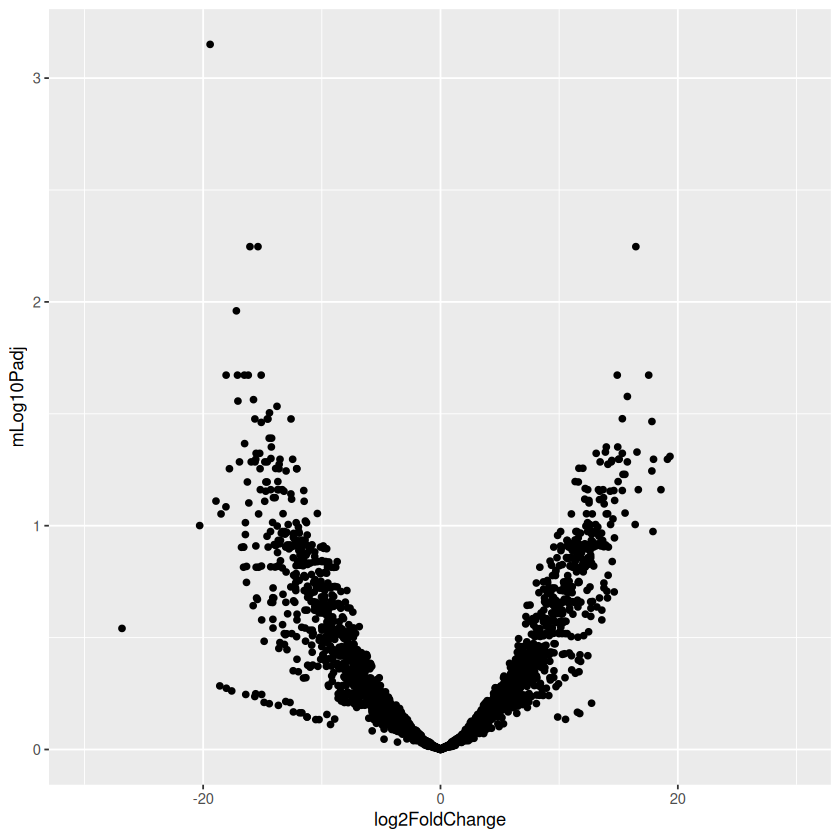

In [129]:
pdata %>% 
    ggplot(aes(x=log2FoldChange, y=mLog10Padj)) + 
    geom_point()

okay, so we see something that resembled a Volcano Plot, but it actually looks pretty terrible.

Let's colour the up and down regulated genes differently just to make this look a bit nicer. To do this, we need to use a conditional column  creator known as "case_when".

### Case When

Useful for conditional modifications on the data

In [131]:
## We will create a "new_pdata" variable, and use "pdata" as the input.
new_pdata = pdata %>% 
    ## Here we create a new column called "highlight" which stores the output of "case_when"
    mutate(highlight = case_when(
        ## Condition 1: if log2FC is greater than 2, then we label it as "upregulated"
        log2FoldChange > 2 ~ "upregulated",
        ## Condition 2: if log2FC is less than -2, then we label it as "downregulated"
        log2FoldChange < -2 ~ "downregulated",
        ## Condition 3: if anything else (i.e. TRUE), then we label it as "boring"
        TRUE ~ "boring"
     )
)
new_pdata %>% head()

gene,log2FoldChange,padj,mLog10Padj,highlight
<chr>,<dbl>,<dbl>,<dbl>,<chr>
0610009L18Rik,NA,NA,NA,boring
0610012D04Rik,0.1109216,0.9936483,0.002767302,boring
0610037L13Rik,-1.1012729,NA,NA,boring
0610040J01Rik,NA,NA,NA,boring
1110002E22Rik,-5.5146408,0.5929138,0.227008467,downregulated
1110004F10Rik,5.3537808,0.5975286,0.223641278,upregulated


Here you can see that we've created a new column that gives a new annotation to each of our genes. Let's plot this.

Warning message:
“Removed 5809 rows containing missing values (`geom_point()`).”


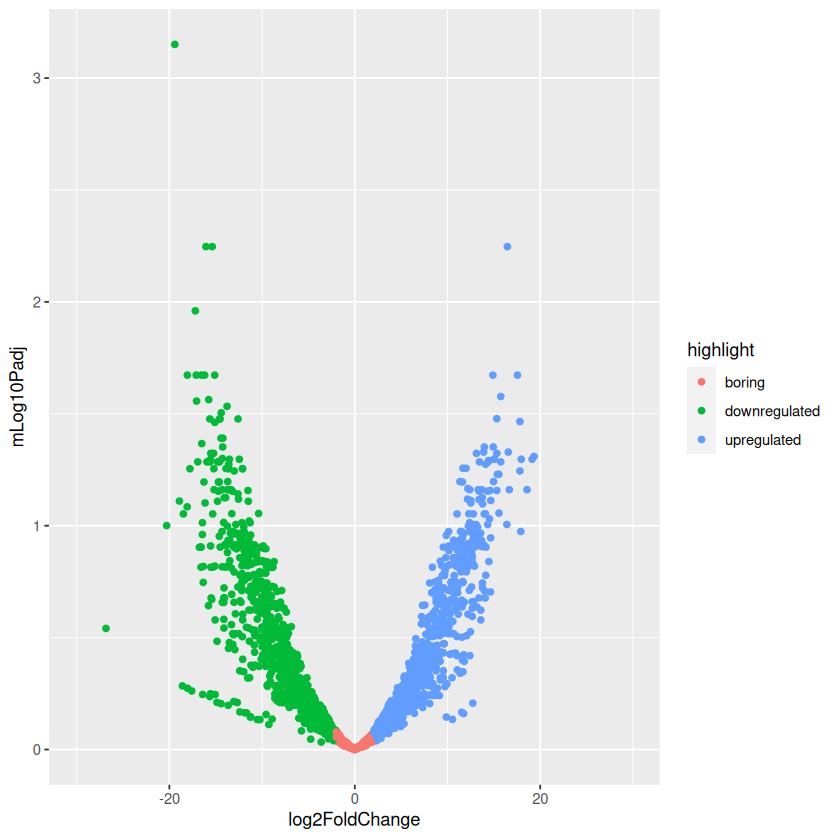

In [132]:
new_pdata %>% 
    # We add a a new aesthetic known as "colour" and tell it to use the highlight column.
    ggplot(aes(x=log2FoldChange, y=mLog10Padj, colour=highlight)) + 
    geom_point()

Okay, that's a little better, but unfortunately it's automatically picked the colours for us.
We can force it to use specific colours for discrete data by using the `scale_colour_manual` function.

Warning message:
“Removed 5809 rows containing missing values (`geom_point()`).”


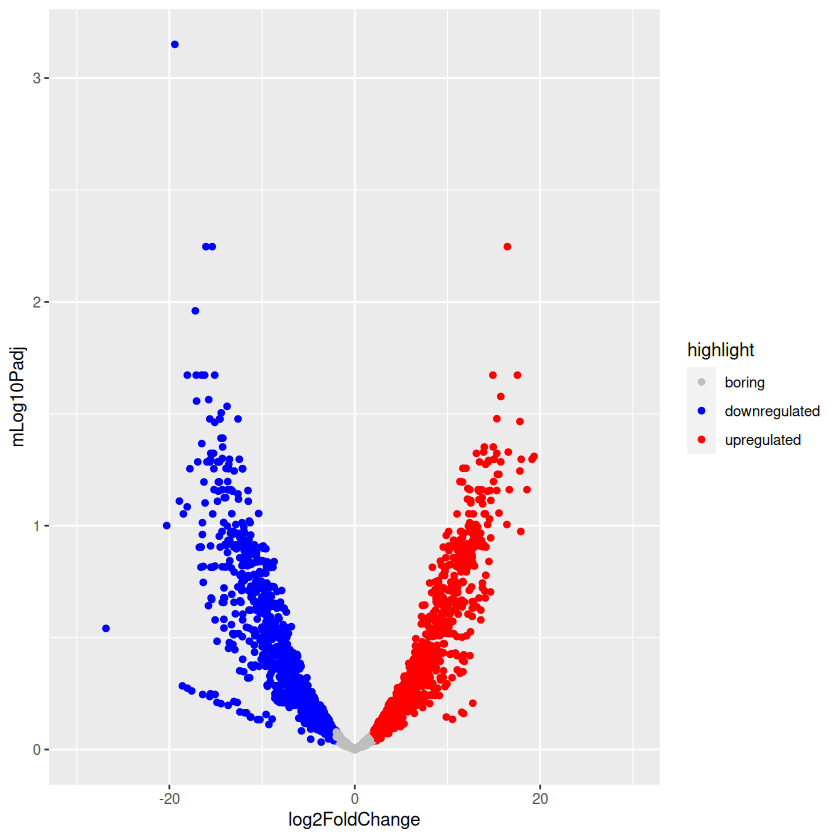

In [133]:
new_pdata %>% 
    ggplot(aes(x=log2FoldChange, y=mLog10Padj, colour=highlight)) + 
    geom_point() + 
    ### upregulated genes should be red, down should be blue, boring should be gray
    scale_colour_manual(values = c("upregulated" = "red",
                                   "downregulated" = "blue",
                                   "boring" = "gray"))

Nice it's looking a little bit better. The boring genes are now at least partially more hidden, and the up and down regulated genes are highlighted much better. However it's looking a little bit squashed, and there is still plenty of empty space in the plot, suggesting we could make better use of it.

### Adding Limits

There is one outlier gene with a very very high p-value of almost 300. It probably is significant, but for now we're going to ignore it and focus on the genes with p-values between 0 and 100. 

Also, we don't need to show all the up and down regulated genes that aren't that significant, so we'll show just the genes with a log2FoldChange between -6 and 6.

Warning message:
“Removed 5815 rows containing missing values (`geom_point()`).”


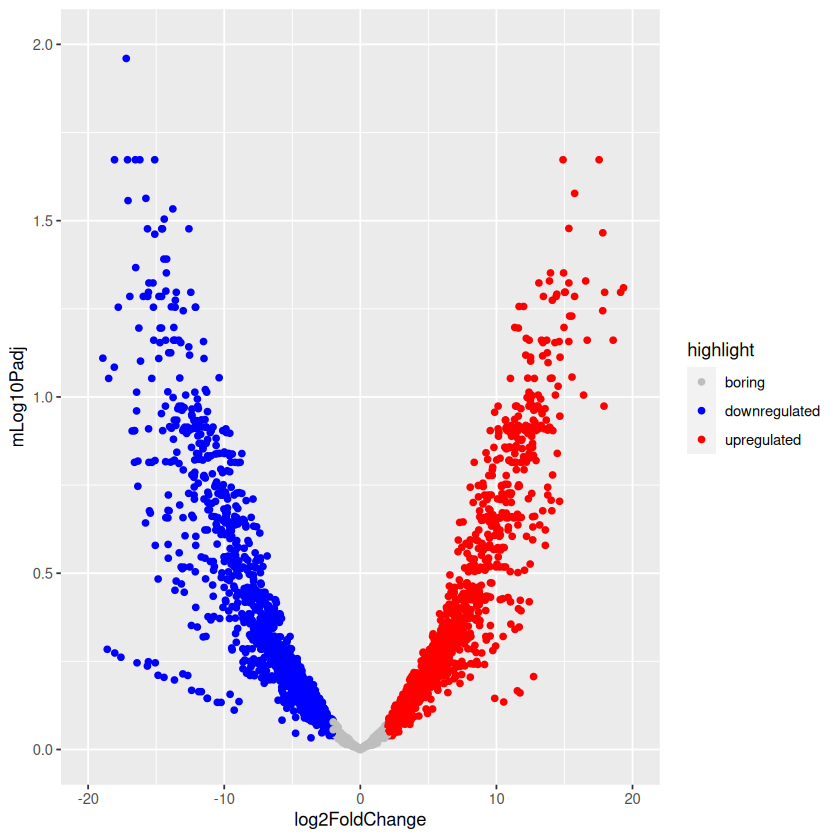

In [134]:
new_pdata %>% 
    ggplot(aes(x=log2FoldChange, y=mLog10Padj, colour=highlight)) + 
    geom_point() + 
    scale_colour_manual(values = c("upregulated" = "red",
                                   "downregulated" = "blue",
                                   "boring" = "gray")) +
    ### Constrain X to -20 to 20, and Y as 0 to 2
    scale_x_continuous(lim = c(-20, 20)) + 
    scale_y_continuous(lim = c(0,2))

Okay, not bad! Looking a little bit better.

Let's annotate these genes. Maybe we shouldn't annotate all of them, but at least the top 20 genes would be nice.

### Top N genes

To select the top n values in a column, we use the top_n function within the tidyverse, and tell it which column  to look at "mLog10Padj" and how many values from to see (n=20).

We're also not interested in any "boring" genes, so we will add an additional filter.

In [138]:
top20data = new_pdata %>% 
    top_n(mLog10Padj, n=20) %>% 
    filter(highlight != "boring")   ## kick out boring genes
top20data

gene,log2FoldChange,padj,mLog10Padj,highlight
<chr>,<dbl>,<dbl>,<dbl>,<chr>
1700086D15Rik,-19.41064,0.0007069354,3.150620,downregulated
Ccl27a,14.89465,0.0212439891,1.672764,upregulated
Fem1c,-16.52786,0.0212439891,1.672764,downregulated
Gm11838,-16.05637,0.0056637587,2.246895,downregulated
Gm14082,-17.06871,0.0277405339,1.556885,downregulated
Gm15607,-16.19825,0.0212439891,1.672764,downregulated
Gm23291,-12.59422,0.0333487356,1.476921,downregulated
Gm27195,-13.77689,0.0292877974,1.533313,downregulated
Gm37102,-15.63852,0.0333487356,1.476921,downregulated


These are our top20 genes.

### Extract these genes, create a TRUE/FALSE column in the original data

We will create a new variable called "our_wanted_genes" that takes the "gene" column from our top20 data above.

In [139]:
our_wanted_genes = top20data$gene
our_wanted_genes

[1] "1700086D15Rik" "Ccl27a"        "Fem1c"         "Gm11838"      
 [5] "Gm14082"       "Gm15607"       "Gm23291"       "Gm27195"      
 [9] "Gm37102"       "Gm37241"       "Gm37282"       "Gm37297"      
[13] "M6pr"          "Parp10"        "Pom121l12"     "RP23-449N19.1"
[17] "Rpl21-ps1"     "Sox21"         "Trim12c"       "Ube4b"        
[21] "Vmn1r91"       "Vmn2r109"

We will now create new column called "isTop20" which will generate a TRUE or FALSE value depending on whether a gene is in the list above. To do this, we will use the "%in%" operator to check whether a value exists in a list.

In [140]:
head(new_pdata)

gene,log2FoldChange,padj,mLog10Padj,highlight
<chr>,<dbl>,<dbl>,<dbl>,<chr>
0610009L18Rik,NA,NA,NA,boring
0610012D04Rik,0.1109216,0.9936483,0.002767302,boring
0610037L13Rik,-1.1012729,NA,NA,boring
0610040J01Rik,NA,NA,NA,boring
1110002E22Rik,-5.5146408,0.5929138,0.227008467,downregulated
1110004F10Rik,5.3537808,0.5975286,0.223641278,upregulated


In [145]:
new_pdata = new_pdata %>% 
    mutate(isTop20 = gene %in% our_wanted_genes)   ## significant if a gene is in our wanted list
new_pdata %>% head()

gene,log2FoldChange,padj,mLog10Padj,highlight,isTop20
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
0610009L18Rik,NA,NA,NA,boring,FALSE
0610012D04Rik,0.1109216,0.9936483,0.002767302,boring,FALSE
0610037L13Rik,-1.1012729,NA,NA,boring,FALSE
0610040J01Rik,NA,NA,NA,boring,FALSE
1110002E22Rik,-5.5146408,0.5929138,0.227008467,downregulated,FALSE
1110004F10Rik,5.3537808,0.5975286,0.223641278,upregulated,FALSE


If we just want to see the Top20 genes in the original data we can filter for them:

In [144]:
new_pdata %>% filter(isTop20 == TRUE)

gene,log2FoldChange,padj,mLog10Padj,highlight,isTop20
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
1700086D15Rik,-19.41064,0.0007069354,3.150620,downregulated,TRUE
Ccl27a,14.89465,0.0212439891,1.672764,upregulated,TRUE
Fem1c,-16.52786,0.0212439891,1.672764,downregulated,TRUE
Gm11838,-16.05637,0.0056637587,2.246895,downregulated,TRUE
Gm14082,-17.06871,0.0277405339,1.556885,downregulated,TRUE
Gm15607,-16.19825,0.0212439891,1.672764,downregulated,TRUE
Gm23291,-12.59422,0.0333487356,1.476921,downregulated,TRUE
Gm27195,-13.77689,0.0292877974,1.533313,downregulated,TRUE
Gm37102,-15.63852,0.0333487356,1.476921,downregulated,TRUE


### Plotting Different Shapes

We will use the `isTop20` column to produce a different shape for the genes in the graph, so that we can highlight which genes are significant.

Warning message:
“Removed 5815 rows containing missing values (`geom_point()`).”


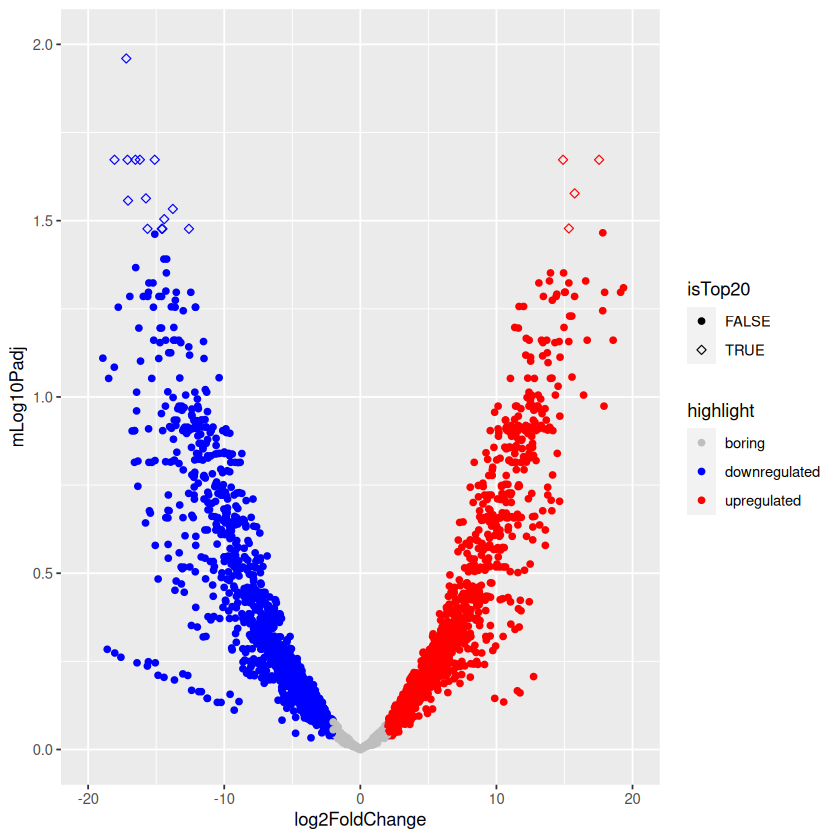

In [146]:
new_pdata %>%
    ggplot(aes(x=log2FoldChange, 
               y=mLog10Padj, 
               colour=highlight,
               shape=isTop20)) +  ## Note: we added a new aesthetic "shape"
    geom_point() + 
    scale_colour_manual(values = c("upregulated" = "red", 
                                   "downregulated" = "blue",
                                   "boring" = "grey")) +
    scale_shape_manual(values = c("TRUE" = 5,
                                  "FALSE" = 19)) + 
    scale_x_continuous(lim = c(-20,20)) + 
    scale_y_continuous(lim = c(0, 2))

Looking good! Notice how we used the `scale_shape_manual` to explicitly tell ggplot which shape values. You can see a list of the different shape values and which number to use to access them [here](http://sape.inf.usi.ch/quick-reference/ggplot2/shape)

### Adding Text

To add labels or text to the data, we can use either geom_text (transparent) or geom_label (with a box):

Warning message:
“Removed 5815 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 5815 rows containing missing values (`geom_label()`).”


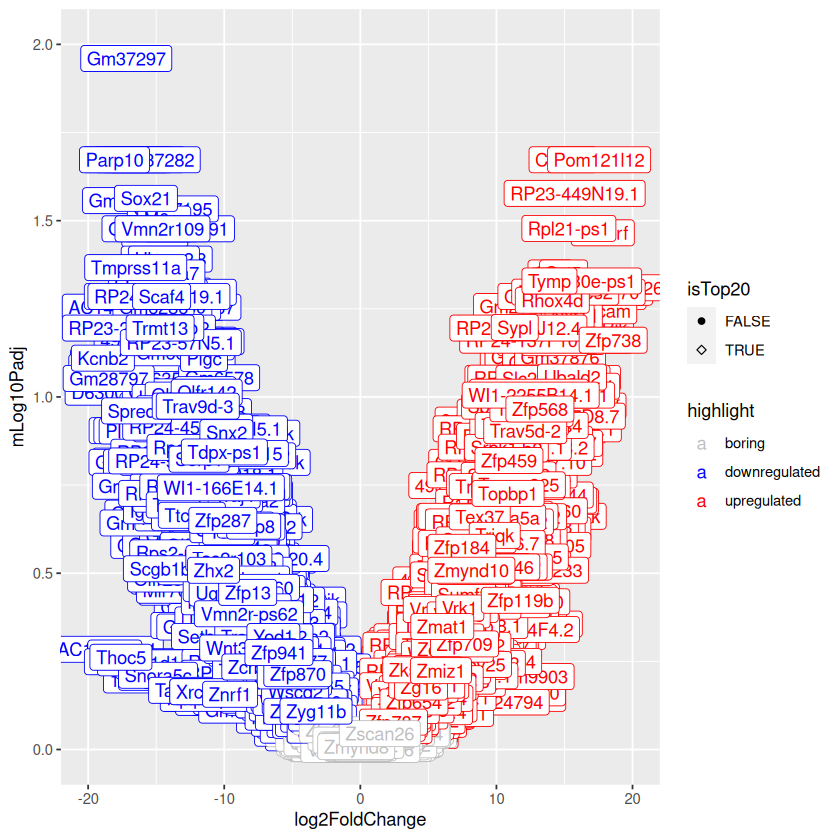

In [147]:
new_pdata %>% 
    ggplot(aes(x=log2FoldChange, 
               y=mLog10Padj, 
               colour=highlight,
               shape=isTop20,
               label=gene)) +    ## Note we've now added a new aesthetic "label"
    geom_point() + 
    scale_colour_manual(values = c("upregulated" = "red", 
                                   "downregulated" = "blue",
                                   "boring" = "grey")) +
    scale_shape_manual(values = c("TRUE" = 5,
                                  "FALSE" = 19)) + 
    scale_x_continuous(lim = c(-20,20)) + 
    scale_y_continuous(lim = c(0, 2)) +
    geom_label()

**horrible! horrible!**

What happened?

* We told it add text to all our genes, not just the top 20 ones. 

Let's fix that.

* Normally when we call a drawing tool such as `geom_point` or `geom_label` we don't need to tell it where to take the data from, since it's implied it will use the one given at the beginning (new_pdata)
* We can **override** this by telling it explicititly which data to use.
* In our case, we will be using new_pdata, but filtered to just show the top20 genes. We accomplish this by writing `new_pdata %>% filter(isTop20 == TRUE)` within geom_label

In [148]:
new_pdata %>% filter(isTop20==TRUE)

gene,log2FoldChange,padj,mLog10Padj,highlight,isTop20
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
1700086D15Rik,-19.41064,0.0007069354,3.150620,downregulated,TRUE
Ccl27a,14.89465,0.0212439891,1.672764,upregulated,TRUE
Fem1c,-16.52786,0.0212439891,1.672764,downregulated,TRUE
Gm11838,-16.05637,0.0056637587,2.246895,downregulated,TRUE
Gm14082,-17.06871,0.0277405339,1.556885,downregulated,TRUE
Gm15607,-16.19825,0.0212439891,1.672764,downregulated,TRUE
Gm23291,-12.59422,0.0333487356,1.476921,downregulated,TRUE
Gm27195,-13.77689,0.0292877974,1.533313,downregulated,TRUE
Gm37102,-15.63852,0.0333487356,1.476921,downregulated,TRUE


Warning message:
“Removed 5815 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_label()`).”


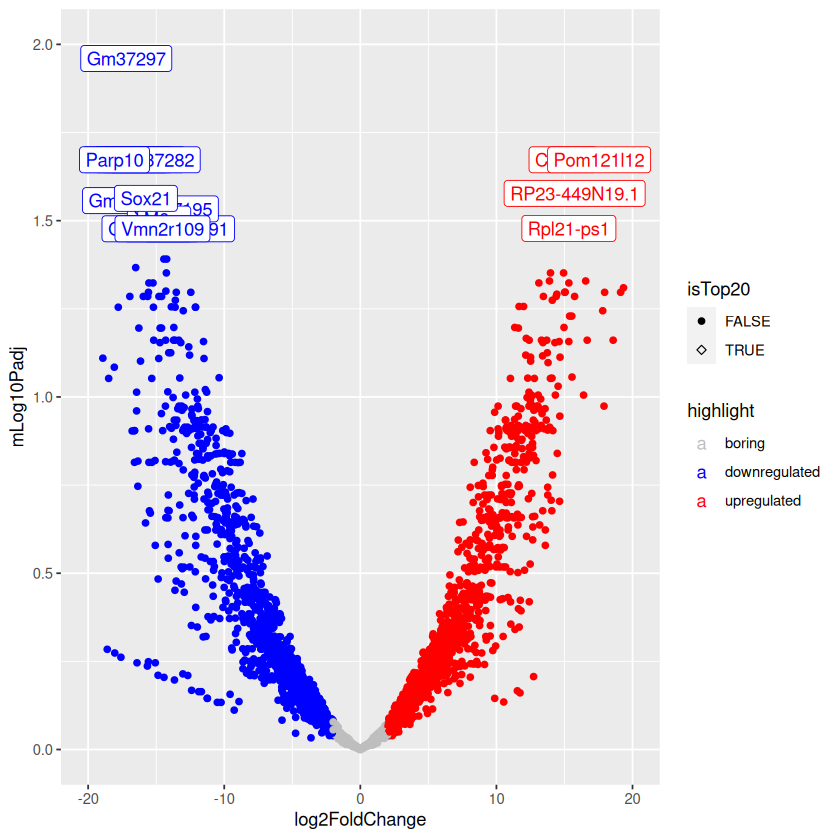

In [149]:
new_pdata %>% 
    ggplot(aes(x=log2FoldChange, 
               y=mLog10Padj, 
               colour=highlight,
               shape=isTop20,
               label=gene)) +    ## Note we've now added a new aesthetic "label"
    geom_point(data=) + 
    scale_colour_manual(values = c("upregulated" = "red", 
                                   "downregulated" = "blue",
                                   "boring" = "grey")) +
    scale_shape_manual(values = c("TRUE" = 5,
                                  "FALSE" = 19)) + 
    scale_x_continuous(lim = c(-20,20)) + 
    scale_y_continuous(lim = c(0, 2)) + 
    geom_label(data=new_pdata %>% filter(isTop20==TRUE))

Here we see all 20 genes, but now let's apply the X-axis limitations:


### Back to the plot!

Let's fix those labels so that they're not overlapping the points. To do this, we will use a new library called `ggrepel`, and this library provides us with a new function `geom_label_repel`.

In [150]:
library(ggrepel)

Warning message:
“Removed 5815 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_label_repel()`).”


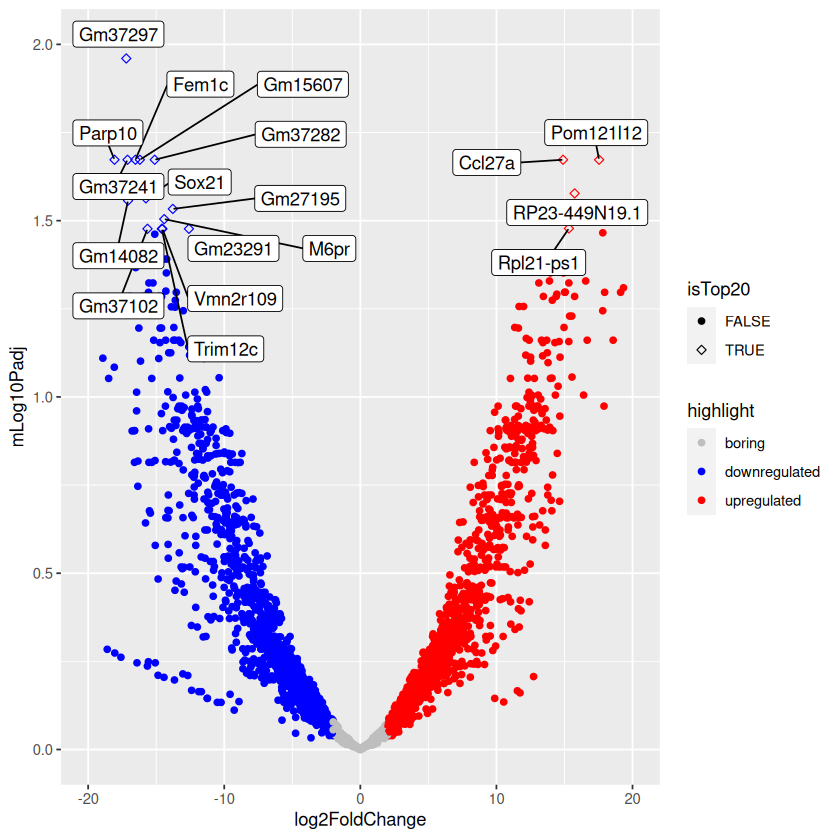

In [151]:
new_pdata %>% 
    ggplot(aes(x=log2FoldChange, 
               y=mLog10Padj, 
               colour=highlight,
               shape=isTop20,
               label=gene)) + 
    geom_point() + 
    scale_colour_manual(values = c("upregulated" = "red", 
                                   "downregulated" = "blue",
                                   "boring" = "grey")) +
    scale_shape_manual(values = c("TRUE" = 5,
                                  "FALSE" = 19)) + 
    scale_x_continuous(lim = c(-20,20)) + 
    scale_y_continuous(lim = c(0, 2)) + 
    geom_label_repel(
        data=new_pdata %>% filter(isTop20 == TRUE),
        box.padding = 0.5, 
        max.overlaps = Inf,
        colour = "black"
    )

Now we have nice floating labels for our significant data points.

### Themeing

This plot is looking good, the background grid is just a little bit grey and boring. Luckily ggplot comes with themes pre-installed that we can use!

https://ggplot2.tidyverse.org/reference/ggtheme.html

First, let's store the plot that we did above into a variable called "plot1".

Warning message:
“Removed 5815 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_label_repel()`).”


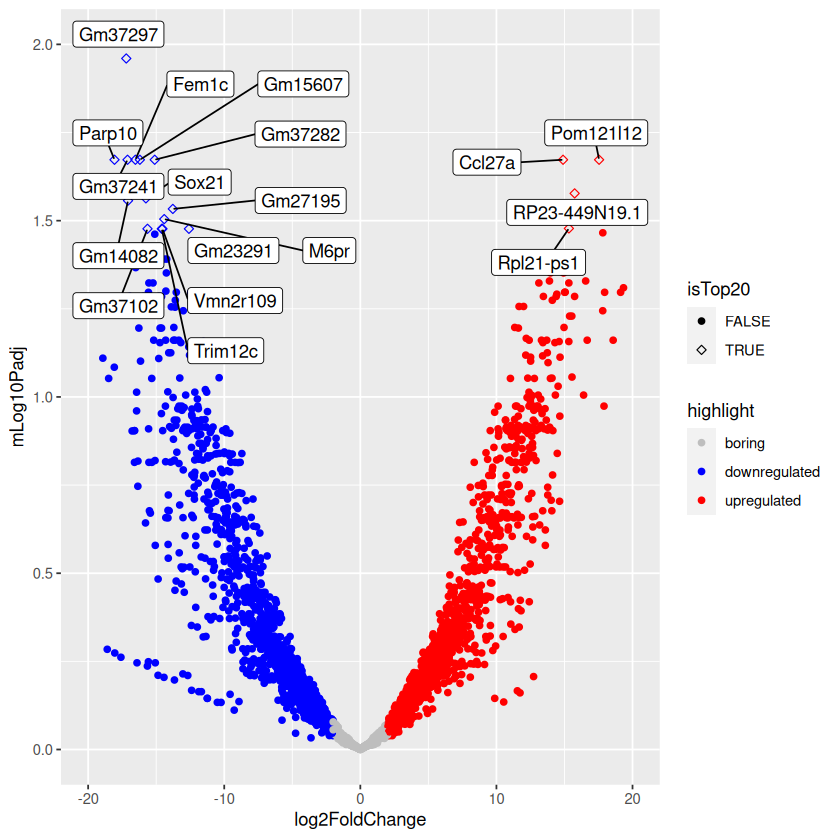

In [152]:
## Store the plot in the variable "plot1"
plot1 = new_pdata %>% 
    ggplot(aes(x=log2FoldChange, 
               y=mLog10Padj, 
               colour=highlight,
               shape=isTop20,
               label=gene)) + 
    geom_point() + 
    scale_colour_manual(values = c("upregulated" = "red", 
                                   "downregulated" = "blue",
                                   "boring" = "grey")) +
    scale_shape_manual(values = c("TRUE" = 5,
                                  "FALSE" = 19)) + 
   scale_x_continuous(lim = c(-20,20)) + 
    scale_y_continuous(lim = c(0, 2)) + 
    geom_label_repel(
        data=new_pdata %>% filter(isTop20 == TRUE),
        box.padding = 0.5, 
        max.overlaps = Inf,
        colour = "black"
    )

## Call the plot to draw it
plot1

Now let's plot different themes and see if it improves the look

Warning message:
“Removed 5815 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_label_repel()`).”


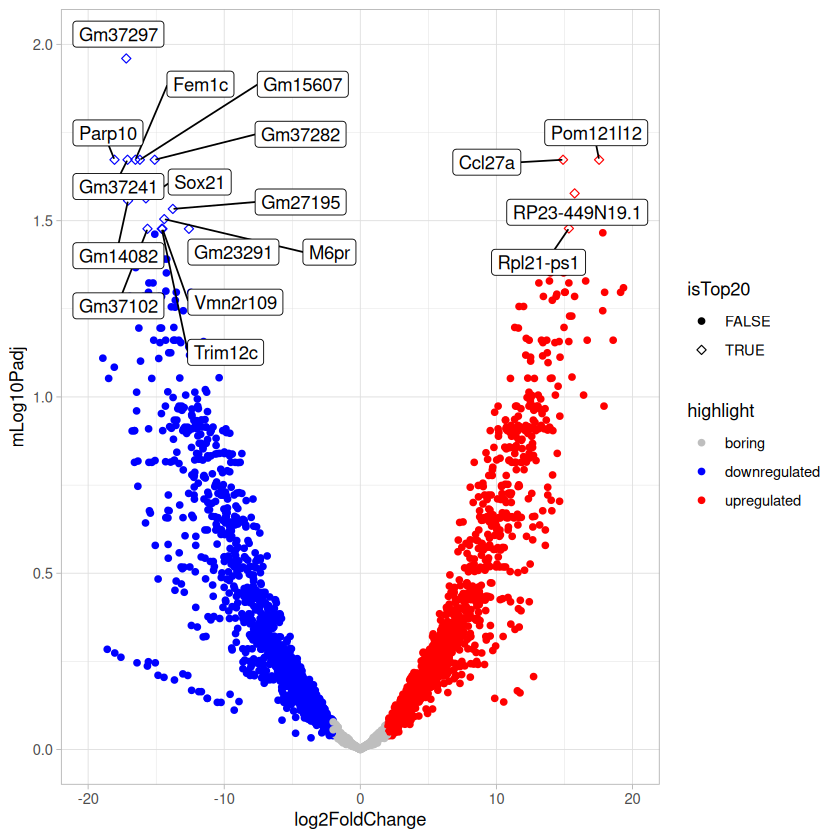

In [153]:
plot1 + theme_light()

Warning message:
“Removed 5815 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_label_repel()`).”


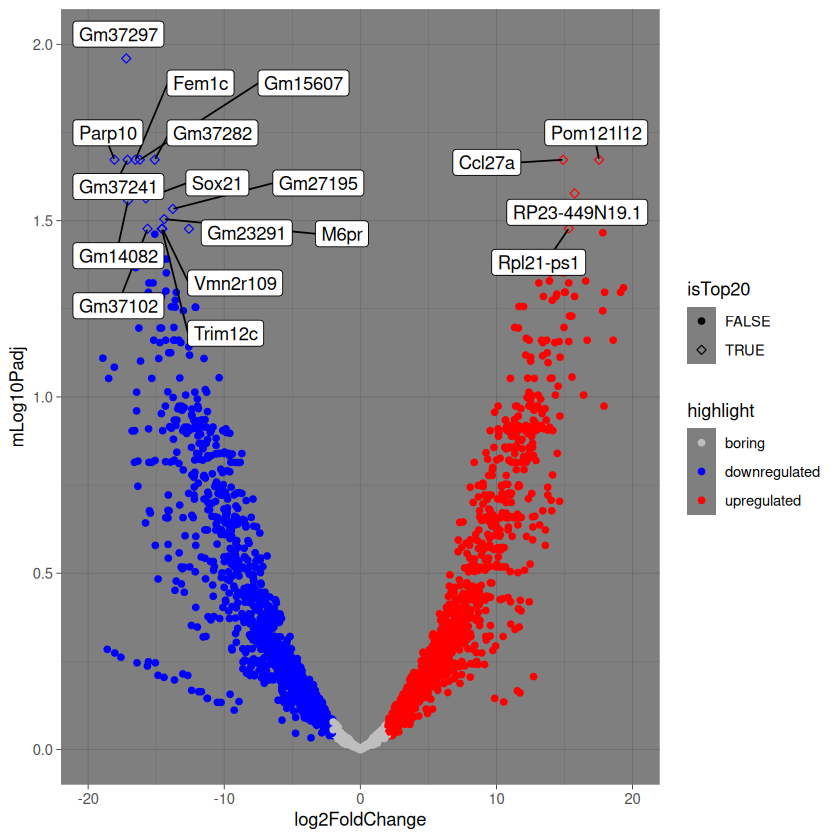

In [155]:
plot1 + theme_dark()

## Saving the Plot

Finally, to save the plot to a file of our choice we case use `ggsave`.

In [156]:
## Save as SVG (easier to edit later in inkscape or Affinity)
ggsave(plot1 + theme_classic(), filename = "myplot.svg", width = 7, height = 7)

Warning message:
“Removed 5815 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_label_repel()`).”


In [159]:
## Save as PNG (visible everywhere)
ggsave(plot1 + theme_classic(), filename = "myplot.png", width = 3000, height = 3000, units = "px")

Warning message:
“Removed 5815 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_label_repel()`).”


Notice that for the PNG plot we changed the format of units from "inches" (default) to pixels "px".